# MELODI Presto Use Cases

In [14]:
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import seaborn as sns
import networkx as nx

from networkx.drawing.nx_pydot import graphviz_layout
from utils import enrich, overlap, sentence, API_URL, plot_overlap_counts


## Configure parameters

In [2]:
requests.get(f"{API_URL}/status").json()

True

# Run the overlap function on some examples

### Genetic basis of psoriasis

https://www.cell.com/ajhg/fulltext/S0002-9297(12)00157-7

In [3]:
q1=['AP1S3','IL36RN','CARD14']
q2=['Psoriasis','Eczema']

overlap_df = overlap(q1,q2)

AP1S3 Psoriasis (0, 32)
AP1S3 Eczema (0, 32)
IL36RN Psoriasis (38, 32)
IL36RN Eczema (0, 32)
CARD14 Psoriasis (40, 32)
CARD14 Eczema (9, 32)


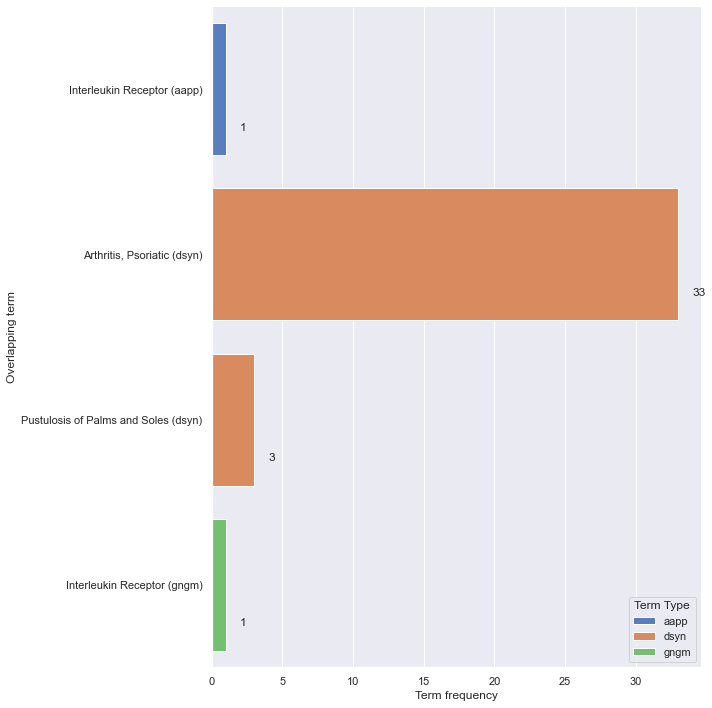

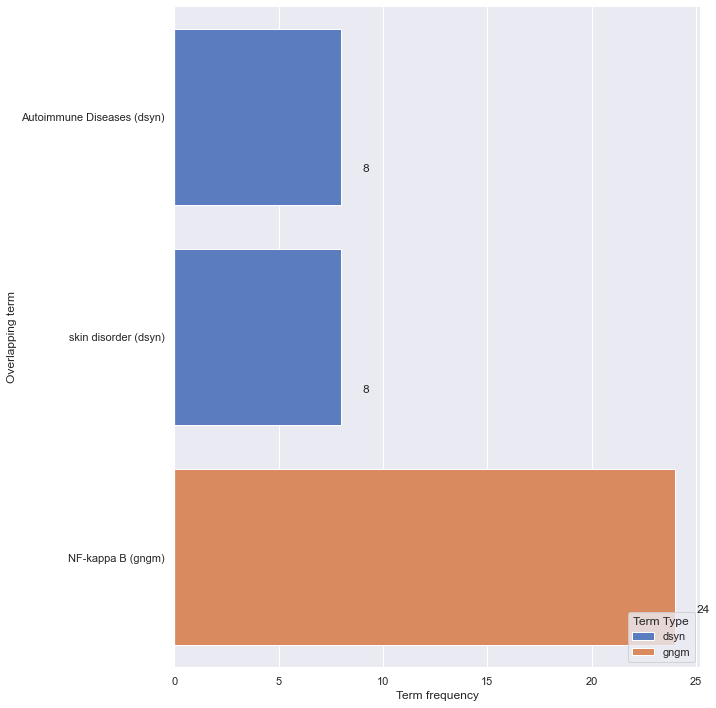

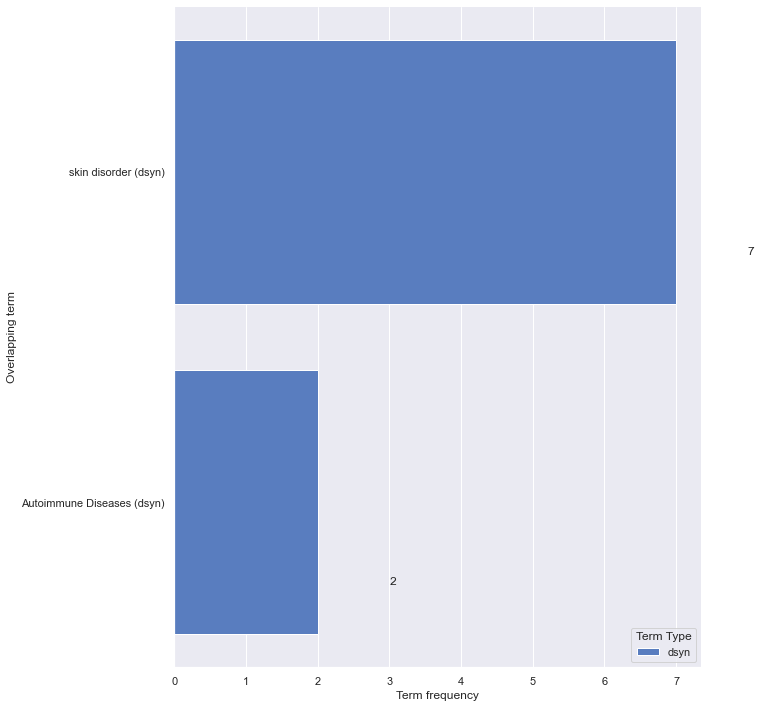

In [4]:
#ignore overlaps containing any of the query terms
overlap_df = overlap_df[~overlap_df['object_name_x'].str.lower().isin([x.lower() for x in q1+q2])]

for i in q1:
    for j in q2:
        overlap_counts = overlap_df[(overlap_df.set_x==i.lower()) & (overlap_df.set_y==j.lower())]
        print(i,j,overlap_counts.shape)
        if not overlap_counts.empty:
            overlap_counts = overlap_counts.groupby(['object_type_x'])['object_name_x'].value_counts()
            #print(overlap_counts)
            plt=plot_overlap_counts(overlap_counts)

### Drug repurposing

https://www.medrxiv.org/content/10.1101/2020.05.07.20093286v1

In [9]:
q1=['DHODH', 'ITGB5', 'JAK2']
q2=['Leflunomide','Cilengitide','Baricitinib']

overlap_df = overlap(q1,q2)
print(overlap_df.head())
overlap_df = overlap_df[~overlap_df['object_name_x'].str.lower().isin([x.lower() for x in q1+q2])]

                                            triple_x  \
0  Dihydroorotate dehydrogenase:INTERACTS_WITH:Py...   
1  Dihydroorotate dehydrogenase:INTERACTS_WITH:Py...   
2  Dihydroorotate dehydrogenase:COEXISTS_WITH:Pyr...   
3  Dihydroorotate dehydrogenase:COEXISTS_WITH:Pyr...   
4                   Enzymes:COEXISTS_WITH:Pyrimidine   

                 subject_name_x subject_type_x subject_id_x     predicate_x  \
0  Dihydroorotate dehydrogenase           aapp     C0058099  INTERACTS_WITH   
1  Dihydroorotate dehydrogenase           aapp     C0058099  INTERACTS_WITH   
2  Dihydroorotate dehydrogenase           aapp     C0058099   COEXISTS_WITH   
3  Dihydroorotate dehydrogenase           aapp     C0058099   COEXISTS_WITH   
4                       Enzymes           enzy     C0014442   COEXISTS_WITH   

  object_name_x object_type_x object_id_x  localCount_x  localTotal_x  ...  \
0    Pyrimidine          orch    C0034284            19           351  ...   
1    Pyrimidine          orch   

In [4]:
overlap_counts = overlap_df.groupby(['set_x','set_y','object_type_x'])['object_name_x'].value_counts()
overlap_counts

set_x  set_y        object_type_x  object_name_x                     
dhodh  leflunomide  aapp           Dihydroorotate dehydrogenase|DHODH     1
                    dsyn           Rheumatoid Arthritis                  18
                    gngm           Dihydroorotate dehydrogenase          50
                                   Dihydroorotate dehydrogenase|DHODH     1
                                   Phosphotransferases                    1
                    orch           Pyrimidine                            12
jak2   baricitinib  aapp           Janus kinase                           5
                                   Janus kinase 1|JAK1                    4
                                   cytokine                               3
                                   TNF protein, human|TNF                 1
                    gngm           Janus kinase                          10
                                   Janus kinase 1|JAK1                    4
                  

In [15]:
#network
def create_network(overlap_df,q1,q2):
    exposure = [x.upper() for x in q1]
    outcome = [x.upper() for x in q2]
    overlap_df.loc[:, "set_x"] = overlap_df["set_x"].apply(
        lambda x: x.upper()
    )
    overlap_df.loc[:, "set_y"] = overlap_df["set_y"].apply(
        lambda x: x.upper()
    )
    # create network data
    d = []
    d = overlap_df[["set_x", "subject_name_x"]].values.tolist()
    d = d + overlap_df[["object_name_y", "set_y"]].values.tolist()
    d = d + overlap_df[["subject_name_x", "object_name_x"]].values.tolist()
    d = d + overlap_df[["subject_name_y", "object_name_y"]].values.tolist()


    def add_newlines(text):
        text = text.replace(" ", "\n")
        return text


    # add newlines to text to make them fit in the nodes! Got to be a better way to do this....
    d_edit = []
    for i in d:
        d_edit.append([add_newlines(x) for x in i])

    # create the edge labels
    labels = {}
    for l in overlap_df[
        ["subject_name_x", "object_name_x", "predicate_x", "localCount_x"]
    ].values.tolist():
        labels[(add_newlines(l[0]), add_newlines(l[1]))] = (
            add_newlines(l[2]) + " (" + str(l[3]) + ")"
        )
    for l in overlap_df[
        ["subject_name_y", "object_name_y", "predicate_y", "localCount_y"]
    ].values.tolist():
        labels[(add_newlines(l[0]), add_newlines(l[1]))] = (
            add_newlines(l[2]) + " (" + str(l[3]) + ")"
        )

    # create the network
    plt.figure(figsize=(15, 15))

    G = nx.Graph(d_edit)

    pos = graphviz_layout(G)

    node_size = 8000

    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=node_size,
        node_color="skyblue",
        font_size=11,
    )

    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=15)

    # colour the GWAS nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=[add_newlines(exposure), add_newlines(outcome)],
        node_color="r",
        node_size=node_size,
        alpha=0.5,
    )
    # plt.show()
    plt.savefig(focus_term + ".png")
    
create_network(overlap_df,q1,q2)

ModuleNotFoundError: No module named 'pydot'

<Figure size 1080x1080 with 0 Axes>

### Obesity and thyroid cancer

https://academic.oup.com/jcem/article/105/7/dgaa250/5835841

object_type_x  object_name_x                     
aapp           ghrelin                               10
               Proto-Oncogene Proteins c-akt|AKT1     4
               PPAR gamma                             3
               Sex Hormone-Binding Globulin           3
               Corticotropin-Releasing Hormone        1
               FRAP1 protein, human|MTOR              1
               Somatostatin                           1
dsyn           Syndrome                              28
               Crohn's disease                        3
               Hypothyroidism                         2
               Thrombophilia                          2
               Thrombus                               1
gngm           PPAR gamma                             6
               Proto-Oncogene Proteins c-akt|AKT1     4
               ghrelin                                3
               MAPKAP1                                1
               Phosphotransferases                    

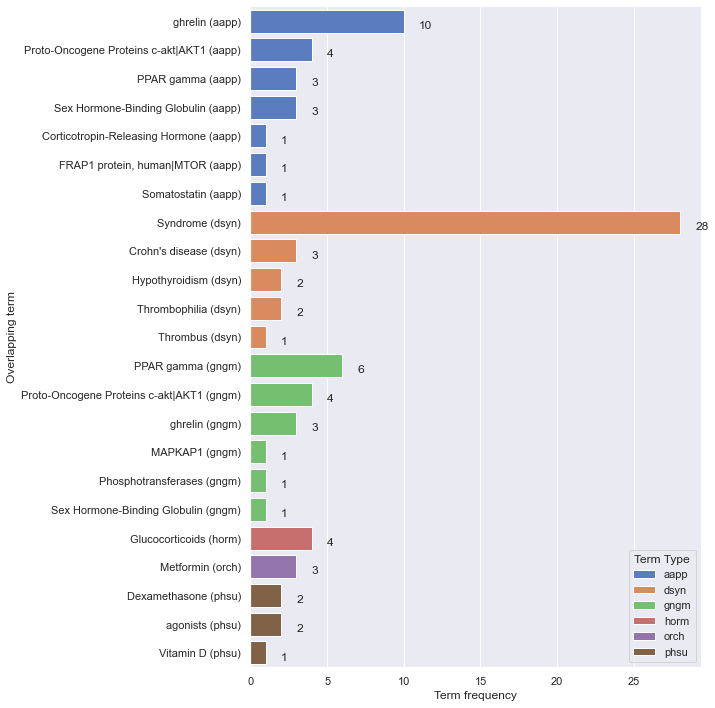

In [5]:
q1=['obesity']
q2=['thyroid cancer']

overlap_df = overlap(q1,q2)
overlap_df = overlap_df[~overlap_df['object_name_x'].str.lower().isin([x.lower() for x in q1+q2])]
overlap_counts = overlap_df.groupby(['object_type_x'])['object_name_x'].value_counts()
print(overlap_counts)
plt=plot_overlap_counts(overlap_counts)

### Coronavirus and dexamethasone

Recent work (https://www.recoverytrial.net/) has demonstrated a potential beneficial effect of dexamethasone on covid-19. Here we can explore the potential intermediates connecting them, including genes, diseases and hormones. We can also separate the two terms `coronavirus` and `covid-19` to distinguish which semantic terms are associated with each query. 

object_type_x  object_name_x                            
aapp           TNF protein, human|TNF                         9
               cytokine                                       8
               TGFB1 protein, human|TGFB1                     3
               human leukocyte interferon|IFNA1               3
               Pulmonary Surfactant-Associated Protein A      2
               Recombinant Interferon-gamma                   2
               Tumor Necrosis Factor-alpha|TNF                2
               Pulmonary Surfactant-Associated Protein D      1
               chemokine                                      1
dsyn           Infection                                     55
               Pneumonia                                     30
               Hypertensive disease                          24
               Bronchiolitis                                  8
               Virus Diseases                                 8
               Obesity                         

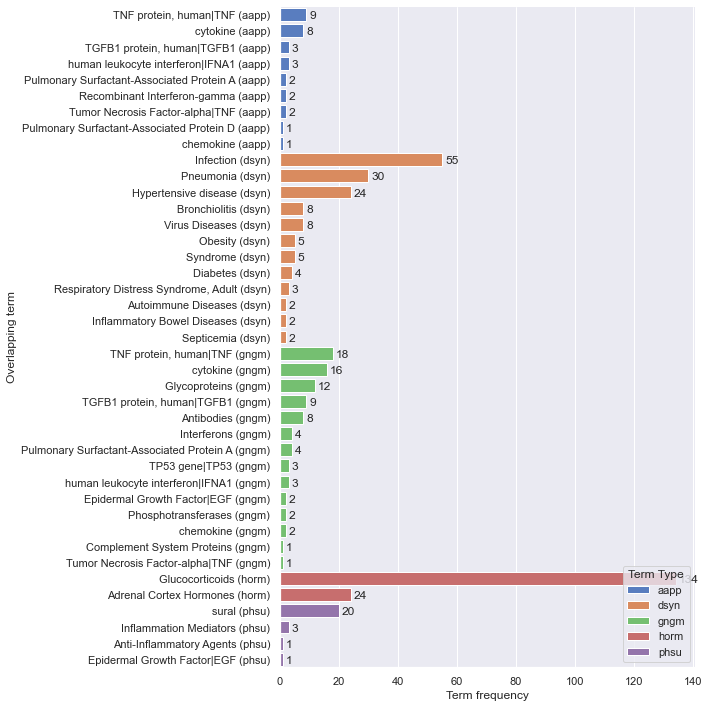

In [6]:
q1=['dexamethasone']
q2=['coronavirus or covid-19']

overlap_df = overlap(q1,q2)
overlap_df = overlap_df[~overlap_df['object_name_x'].str.lower().isin([x.lower() for x in q1+q2])]
overlap_counts = overlap_df.groupby(['object_type_x'])['object_name_x'].value_counts()
print(overlap_counts)

plt=plot_overlap_counts(overlap_counts)
plt.savefig('overlaps.png',dpi=1000)


# Identifying risk factors for a disease

We can explore one disease in detail to identify risk factors. In this case, `asthma`.

In [53]:
q='asthma'
enrich_df=enrich(q)

#map to objects that contain the query term
enrich_df = enrich_df[enrich_df['object_name'].str.contains(q,case=False)]
#print(enrich_df)
print(enrich_df.shape)

#list of risk factor predicates
rf_preds=['CAUSES','PREDISPOSES','PRECEDES','STIMULATES']
rf=enrich_df[enrich_df['predicate'].isin(rf_preds)]

#make sure pval is a float
rf['pval']=rf['pval'].astype(float)

#look at the top 20 ordered by enrichment pvalue
rf.sort_values(by='pval',ascending=True).head(20)[['subject_name','subject_type','predicate','object_name','pval','localCount']]

(3161, 16)


/Users/be15516/anaconda3/envs/MelodiPresto/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,subject_name,subject_type,predicate,object_name,pval,localCount
1,Ovalbumin,aapp,CAUSES,Asthma,0.000000e+00,686
6,Tolylene Diisocyanate,hops,CAUSES,Asthma,0.000000e+00,299
10,Obesity,dsyn,PREDISPOSES,Asthma,2.231166e-269,194
13,Ovalbumin,aapp,CAUSES,Extrinsic asthma NOS,9.277513e-231,166
20,Irritants,hops,CAUSES,Asthma,1.240808e-165,119
22,Isocyanates,orch,CAUSES,Asthma,7.125863e-163,117
31,Isocyanates,orch,CAUSES,Occupational asthma,1.792807e-142,102
38,Tolylene Diisocyanate,hops,CAUSES,Occupational asthma,1.557261e-124,89
44,Allergic rhinitis NOS,dsyn,PREDISPOSES,Asthma,5.684155e-108,77
48,cytokine,aapp,CAUSES,Asthma,2.969208e-95,68


# All against all

The excellent performance capabilities of MELODI Presto means we can perform an all-against-all analysis for a range of terms, e.g. a list of genes and diseases. This can create a network, highlighting potential shared mechanisms of action. 

As an example we examine the relationships between 

In [17]:
#just run enrich on each then create network